#  <font color='blue'>Machine Learning in Stock Selection</font>

##  <font color='red'>1. Import Pacakge</font>

In [1]:
import numpy as np     # Matrix Computation
import pandas as pd    # Handle Dataframe

# Show plot in this notebook
%matplotlib inline               
import matplotlib.pyplot as plt  # Plotting

from sklearn.model_selection import train_test_split # Split training and test set
from sklearn.model_selection import GridSearchCV     # Select hyper-parameter by cross-validation error 
from sklearn import metrics as me

# Machine Learning Model
from sklearn.svm import SVC                                     # Support Vector Machine
from sklearn.ensemble import RandomForestClassifier as RFC      # Random Forest
from sklearn.ensemble import GradientBoostingClassifier as GBC  # Gradient Boosted

##  <font color='red'>2. Parameter Setting</font>

In [2]:
class PARA:
    method = 'SVM'  # 'RF', 'GBT'
    month_train = range(1, 84+1)          # In-sample 84 data points = 84 training examples
    month_test = range(85, 120+1)         # Out-of-sample 36 data points = 36 test examples
    percent_select  = [0.5, 0.5]          # 50% positive examples，50% negative examples
    cv = 10                               # 10-fold cross-validation
    seed = 1                              # Random seed, for results reproduction
para = PARA()

##  <font color='red'>3. Data Labeling</font>

In [3]:
def label_data( data ):
    data['Label'] = np.nan                                        # Initialization
    data = data.sort_values( by='Return', ascending=False )       # Sort excess return in descending order
    n_stock = np.multiply( para.percent_select, data.shape[0] )   # Compute the number for stocks for positive and negative class
    n_stock = np.around(n_stock).astype(int)                      # Round number of stocks to integer
    data.iloc[0:n_stock[0], -1] = 1                               # Assign 1 to those stocks with best performace 
    data.iloc[-n_stock[1]:, -1] = 0                               # Assign 0 to those stocks with worst performace 
    data = data.dropna(axis=0)                                    # Delete examples with NaN value
    return data

In [4]:
for i in para.month_train:
    # load csv month by month
    file_name = str(i) + '.csv'
    data_curr_month = pd.read_csv( file_name, header=0 )
    para.n_stock = data_curr_month.shape[0]
    
    # remove NaN
    data_curr_month = data_curr_month.dropna(axis=0)
    
    # label data
    data_curr_month = label_data( data_curr_month )
    
    # merger to a single dataframe
    if i == para.month_train[0]: # first month
        data_train = data_curr_month
    else:
        data_train = data_train.append(data_curr_month)

##  <font color='red'>4. Data Preprocessing</font>

In [5]:
X = data_train.loc[:, 'EP':'BIAS'];
y = data_train.loc[:, 'Label'];

#X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=para.percent_cv, random_state=para.seed)
X_train = X
y_train = y

##  <font color='red'>5. Model Setting</font>

In [6]:
if para.method == 'SVM':                                # Support Vector Machine
    model = SVC( kernel = 'rbf', C = 0.01 )
elif para.method == 'RF':                               # Random Forest 
    model = RFC( n_estimators=200, max_depth=6, random_state=para.seed )
elif para.method == 'GBT':                              # Gradient Boosted Tree 
    model = GBC( n_estimators=200, max_depth=6,  random_state=para.seed )

##  <font color='red'>6. Model Training</font>

In [7]:
# Train SVM model given it is with RBF kernel and 0.01 penalty coefficient
model.fit( X_train, y_train )
Y_pred_train = model.predict( X_train )
Y_score_train = model.decision_function( X_train )

In [8]:
# Select best hyper-parameter by cross-validation error
parameters = { 'kernel':('linear', 'rbf'), 'C':[0.01, 0.1, 1, 10] }
GS = GridSearchCV( model, parameters, cv=para.cv )
GS.fit( X_train, y_train )

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [9]:
#GS.cv_results_
GS.best_params_, GS.best_score_

({'C': 0.01, 'kernel': 'rbf'}, 0.51468253968253963)

In [10]:
best_model = SVC( kernel = GS.best_params_['kernel'], C = GS.best_params_['C'] )
best_model.fit( X_train, y_train )
y_pred_train = best_model.predict( X_train )
y_score_train = best_model.decision_function( X_train )

print( 'training set, accuracy = %.2f' %me.accuracy_score( y_train, y_pred_train ) )
print( 'training set, AUC = %.2f' %me.roc_auc_score( y_train, y_score_train ) )

training set, accuracy = 0.63
training set, AUC = 0.68


##  <font color='red'>7. Model Assessment</font>

In [11]:
A = pd.DataFrame( [np.nan]*np.ones((para.n_stock, para.month_test[-1])) )
y_true_test = A
y_pred_test = A
y_score_test = A

for i in para.month_test:
    file_name = str(i) + '.csv'
    data_curr_month = pd.read_csv( file_name, header=0 )
    
    # remove NaN
    data_curr_month = data_curr_month.dropna(axis=0)
    X_curr_month = data_curr_month.loc[:,'EP':'BIAS']

    y_pred_curr_month = best_model.predict( X_curr_month )
    y_score_curr_month = best_model.decision_function( X_curr_month )

    idx = data_curr_month.index
    
    y_true_test.iloc[ idx, i-1 ] = data_curr_month['Return'][idx]
    y_pred_test.iloc[ idx, i-1 ] = y_pred_curr_month
    y_score_test.iloc[ idx, i-1 ] = y_score_curr_month

y_pred_test[y_pred_test>0] = 1
y_pred_test[y_pred_test<0] = 0

In [12]:
for i in para.month_test:       # Print accuracy and AUC for each test example 
    y_true_i_month = pd.DataFrame( {'Return':y_true_test.iloc[:,i-1]} )
    y_pred_i_month = y_pred_test.iloc[:,i-1]
    y_score_i_month = y_score_test.iloc[:,i-1]

    # remove NaN
    y_true_i_month = y_true_i_month.dropna(axis=0)
    
    y_i_month = label_data( y_true_i_month )['Label']

    y_pred_i_month = y_pred_i_month[ y_i_month.index ].values
    y_score_i_month = y_score_i_month[ y_i_month.index ].values

    print( 'test set, month %d, accuracy = %.2f' %(i, me.accuracy_score( y_i_month, y_pred_i_month ) ) )
    print( 'test set, month %d, AUC = %.2f' %(i, me.roc_auc_score( y_i_month, y_score_i_month ) ) )

test set, month 85, accuracy = 0.90
test set, month 85, AUC = 0.90
test set, month 86, accuracy = 0.90
test set, month 86, AUC = 0.90
test set, month 87, accuracy = 0.97
test set, month 87, AUC = 0.97
test set, month 88, accuracy = 0.93
test set, month 88, AUC = 0.93
test set, month 89, accuracy = 0.93
test set, month 89, AUC = 0.93
test set, month 90, accuracy = 0.90
test set, month 90, AUC = 0.90
test set, month 91, accuracy = 0.93
test set, month 91, AUC = 0.93
test set, month 92, accuracy = 0.93
test set, month 92, AUC = 0.93
test set, month 93, accuracy = 0.93
test set, month 93, AUC = 0.93
test set, month 94, accuracy = 0.90
test set, month 94, AUC = 0.90
test set, month 95, accuracy = 0.83
test set, month 95, AUC = 0.83
test set, month 96, accuracy = 0.97
test set, month 96, AUC = 0.97
test set, month 97, accuracy = 0.90
test set, month 97, AUC = 0.90
test set, month 98, accuracy = 0.93
test set, month 98, AUC = 0.93
test set, month 99, accuracy = 0.80
test set, month 99, AUC = 

##  <font color='red'>8. Strategy Implementation</font>

In [13]:
n_stock = 20
strategy = pd.DataFrame( {'Return':[0]*para.month_test[-1], 'Value':[1]*para.month_test[-1]} )

for i in para.month_test:
    y_true_i_month = y_true_test.iloc[:,i-1]
    y_score_i_month = y_score_test.iloc[:,i-1]

    y_score_i_month = y_score_i_month.sort_values(ascending=False)     # Sort the score (probability of up) in descending order
    i_index = y_score_i_month[0:n_stock].index                         # Find the index of the first 20 stocks

    strategy.loc[i-1,'Return'] = np.mean(y_true_i_month [i_index])     # Compute the mean return of the 20 stocks

strategy['Value'] = (strategy['Return']+1).cumprod()                   # Mutiply the mean return each test month to get total return

##  <font color='red'>9. Strategy Assessment</font>

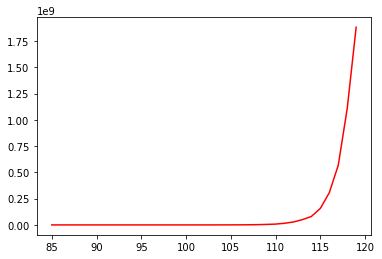

annual excess return = 9.84
annual excess volatility= 0.41
information ratio = 24.23


In [14]:
plt.plot( para.month_test, strategy.loc[para.month_test,'Value'] , 'r-' )
plt.show()

excess_return = np.mean(strategy.loc[para.month_test,'Return']) * 12         # Compute annualized excess return
excess_vol = np.std(strategy.loc[para.month_test,'Return']) * np.sqrt(12)    # Compute annualized volatility of excess return
IR = excess_return / excess_vol                                              # Compute information ratio

print( 'annual excess return = %.2f' %excess_return )
print( 'annual excess volatility= %.2f' %excess_vol )
print( 'information ratio = %.2f' %IR)